## Calibration of model parameters (BLACK and SCHOLES, MERTON)
The **Implied Volatility** is that value $\\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
$$ BS(S, K, T, r, \sigma) = P  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.


In [5]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo


Let's retrieve the historic prices for european call and put options starting from 2016-01-20 and expiring 1 year later.

In [6]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')

df_call['C_Midpoint'] = abs(df_call['C_BID'] + df_call['C_ASK']) / 2
df_put['P_Midpoint'] = abs(df_put['P_BID'] + df_put['P_ASK']) / 2
df_call['C_Spread'] = df_call['C_BID'] - df_call['C_ASK']
df_put['P_Spread'] = df_put['P_BID'] - df_put['P_ASK']

q = 0       # dividend yield
r = 0.05     # risk-free interest rate
sigma = 0.2 #volatility (variance of diffusion process)
S0 = df_call.iloc[0]['UNDERLYING_LAST']
T = 1
call_strikes = df_call['STRIKE']    # array of K
put_strikes = df_put['STRIKE']
exercise = 'european'

call_prices = df_call['C_Midpoint']
put_prices = df_put['P_Midpoint']

Let's initialize an object of class BS_pricer which is able to find the theoretical price of the options, given the parameters.

In [7]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.05, q = q, sigma=0.15, lambd=0.7, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.4, eta1=10, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=0.5, nu=0.08, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    vg = VG.closed_formula_call(K)
    call_th_prices.loc[i] = [bs, mert, kou, vg]

print(f'Theoretical call options prices:')
print(call_th_prices)


Theoretical call options prices:
    BlackScholes      Merton         Kou  VarianceGamma
0     742.285318  742.994403  748.255078     743.737883
1     718.704250  719.528691  725.251929     720.426322
2     695.187334  696.131390  702.324826     697.206620
3     671.749945  672.814202  679.480443     674.092356
4     648.409713  649.590213  656.726317     651.098332
5     625.186545  626.473953  634.071044     628.240575
6     602.102593  603.481443  611.524476     605.536314
7     579.182158  580.630238  589.097955     583.003940
8     556.451527  557.939447  566.804532     560.662948
9     533.938761  535.429734  544.659190     538.533860
10    511.673419  513.123305  522.679043     516.638127
11    489.686238  491.043863  500.883493     494.998017
12    468.008771  469.216537  479.294330     473.636478
13    446.672996  447.667779  457.935767     452.576989
14    425.710906  426.425220  436.834388     431.843394
15    405.154090  405.517490  416.019008     411.459723
16    385.03331

In [8]:
vg_fft = VG.FFT_call(call_strikes)

for a, b in zip(vg, vg_fft):
    print(a, b)

TypeError: the first argument must be callable

PUT PRICES:

In [9]:
put_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.loc[i] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    BlackScholes      Merton         Kou  VarianceGamma
0       0.499891    1.208977    6.469652       1.952457
1       0.699559    1.524001    7.247238       2.421631
2       0.963379    1.907435    8.100871       2.982665
3       1.306726    2.370982    9.037223       3.649136
4       1.747229    2.927729   10.063834       4.435848
5       2.304796    3.592205   11.189296       5.358827
6       3.001581    4.380430   12.423464       6.435302
7       3.861881    5.309961   13.777678       7.683663
8       4.911986    6.399905   15.264990       9.123407
9       6.179956    7.670928   16.900384      10.775054
10      7.695349    9.145234   18.700973      12.660057
11      9.488904   10.846528   20.686159      14.800683
12     11.592172   12.799939   22.877731      17.219880
13     14.037133   15.031916   25.299904      19.941126
14     16.855779   17.570092   27.979261      22.988267
15     20.079698   20.443098   30.944616      26.385331
16     23.739660

In [10]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method, disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        #X0 = [0.03, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2]   # set of
        X0 = [0.1, 0.5, 1, 3]
        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Let's now compute the implied volatilities from the true market prices *call_prices*.

In [11]:
IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(call_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].values[i], S=S0, strike=call_strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_VG.append(implied_volatility(call_th_prices['VarianceGamma'].values[i], S=S0, strike=call_strikes[i], t = T, rate=r, q=q, type_o='call', method='fsolve'))

imp_vol_call = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K
imp_vol_call['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call}')

Implied volatilities found by each model for call options:
    BlackScholes    Merton       Kou  VarianceGamma
0            0.2  0.222448  0.288750       0.237498
1            0.2  0.220874  0.284492       0.236066
2            0.2  0.219323  0.280254       0.234655
3            0.2  0.217792  0.276038       0.233262
4            0.2  0.216283  0.271848       0.231887
5            0.2  0.214795  0.267687       0.230530
6            0.2  0.213327  0.263562       0.229190
7            0.2  0.211880  0.259481       0.227866
8            0.2  0.210453  0.255454       0.226557
9            0.2  0.209046  0.251490       0.225264
10           0.2  0.207661  0.247600       0.223986
11           0.2  0.206298  0.243798       0.222722
12           0.2  0.204957  0.240095       0.221472
13           0.2  0.203640  0.236503       0.220235
14           0.2  0.202347  0.233032       0.219011
15           0.2  0.201080  0.229694       0.217799
16           0.2  0.199839  0.226496       0.216600
17   

In [12]:
IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=put_strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_VG.append(implied_volatility(put_th_prices['VarianceGamma'].values[i], S=S0, strike=put_strikes[i], t = T, rate=r, q=q, type_o='put', method='fsolve'))

imp_vol_put = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K
imp_vol_put['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put}')

Implied volatilities found by each model for put options:
     BlackScholes    Merton       Kou  VarianceGamma
0            0.2  0.222448  0.288750       0.237498
1            0.2  0.220874  0.284492       0.236066
2            0.2  0.219323  0.280254       0.234655
3            0.2  0.217792  0.276038       0.233262
4            0.2  0.216283  0.271848       0.231887
5            0.2  0.214795  0.267687       0.230530
6            0.2  0.213327  0.263562       0.229190
7            0.2  0.211880  0.259481       0.227866
8            0.2  0.210453  0.255453       0.226557
9            0.2  0.209046  0.251490       0.225264
10           0.2  0.207661  0.247600       0.223986
11           0.2  0.206298  0.243798       0.222722
12           0.2  0.204957  0.240095       0.221472
13           0.2  0.203640  0.236503       0.220235
14           0.2  0.202347  0.233032       0.219011
15           0.2  0.201080  0.229694       0.217799
16           0.2  0.199839  0.226496       0.216600
17   

Plot of the implied volatilities with respect to the strike price.

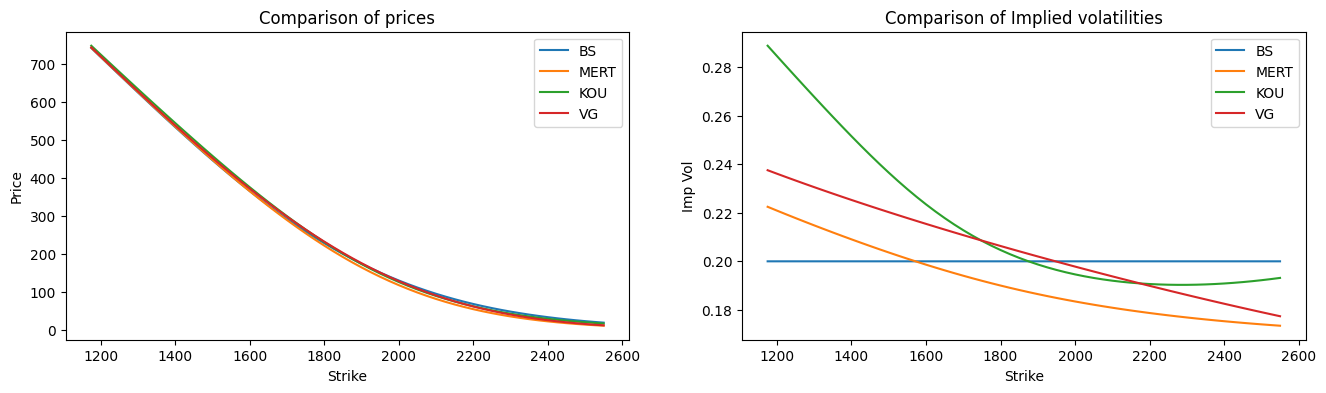

In [13]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU"); ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label="VG")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU"); ax2.plot(call_strikes, imp_vol_call['VarianceGamma'], label="VG")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

## Calibration of Merton Jump Diffusion parameters
First we'll initialize a starting point in the array $x_0 = [σ, λ, m, v]$
and we set bounds for the 4 parameters. Then we use the method
1. **curve_fit** of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [9]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 0, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)
#

- Method 1. curve_fit of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [10]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.10371
> Calibrated Jump intensity [λ] =  0.09
> Calibrated Jump Mean =  0.11
> Calibrated Jump St. dev.  =  0.1


In [11]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],5)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print('> Calibrated Volatlity [σ] = ', sigt2)
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:50: RuntimeWarning: overflow encountered in exp
  mean = np.exp(self.meanJ + self.stdJ ** 2 / 2)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:51: RuntimeWarning: invalid value encountered in scalar multiply
  r_k = self.r - self.lambd * (mean - 1) + (k * np.log(mean)) / self.ttm
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in exp
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in scalar power
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \


METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)
> Calibrated Volatlity [σ] =  -0.19794
> Calibrated Jump intensity [λ] =  -0.05
> Calibrated Jump Mean =  -42.39
> Calibrated Jump St. dev.  =  9.06846


- Method 2. minimize(method=’SLSQP’)

In [12]:
x0 = [0.3, 0.8, -0.1, 0.4] # initial guess: [σ, λ, m, v]
bounds = [(1e-6, 10), (0, np.inf), (-10, np.inf),  (0, np.inf)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)

print(res2)
sigt, lambdt, mt, vt = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('Calibrated Volatility [σ] =', round(sigt, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt, 2))
print('Calibrated Jump Mean [m] =', round(mt, 2))
print('Calibrated Jump St. dev. [v] =', round(vt, 2))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 2.997e-01  6.285e+02  7.717e+02  2.539e+03]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 20
    njev: 2
> METHOD 2: MINIMIZE (SLSQP)
Calibrated Volatility [σ] = 0.29971
Calibrated Jump Intensity [λ] = 628.5
Calibrated Jump Mean [m] = 771.68
Calibrated Jump St. dev. [v] = 2538.65


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:50: RuntimeWarning: overflow encountered in exp
  mean = np.exp(self.meanJ + self.stdJ ** 2 / 2)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:51: RuntimeWarning: invalid value encountered in scalar multiply
  r_k = self.r - self.lambd * (mean - 1) + (k * np.log(mean)) / self.ttm
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:51: RuntimeWarning: invalid value encountered in scalar add
  r_k = self.r - self.lambd * (mean - 1) + (k * np.log(mean)) / self.ttm
C:\Users\ornel\OneDrive\Desktop\TE

## Calibration of Kou Jump Diffusion parameters

In [13]:
x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_1]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )

def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

Method scipy.optimize: curve_fit

In [14]:
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Upward Jump probability = ', pt)
print('> Calibrated Rate of Exp. 1  = ', eta1_t)
print('> Calibrated Rate of Exp. 2  = ', eta2_t)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.11031
> Calibrated Jump intensity [λ] =  0.01
> Calibrated Upward Jump probability =  0.9
> Calibrated Rate of Exp. 1  =  5.3
> Calibrated Rate of Exp. 2  =  10.0


#### Method 2: minimize function

In [21]:
x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_1]
bounds = [(0, 4), (0, 10), (0, 1),  (0, 10), (0,10)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, p, eta1, eta2 = x
    KouJD = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return np.sum((KouJD.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print(res2)

sigt, lambdt, pt, eta1_t, eta2_t = res2.x

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Upward Jump probability = ', pt)
print('> Calibrated Rate of Exp. 1  = ', eta1_t)
print('> Calibrated Rate of Exp. 2  = ', eta2_t)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:144: RuntimeWarning: invalid value encountered in scalar divide
  p2 = self.p / (1 + zeta) * self.eta1 / (self.eta1 - 1)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  sum_p = sum_p + ssp.binom(n - k - 1, i - k) * ssp.binom(n, i) * (eta1 / (eta1 + eta2)) \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  ** (i - k) * (eta2 / (eta1 + eta2)) ** (n - i) * p ** i * q ** (n - i)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\KOUpricer.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  sum_q = sum_q + ssp.binom(n - k - 1, i - k) * ssp.binom(n, i) * (eta1 / (eta1

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 0.0
       x: [ 1.866e-02  1.749e+00  0.000e+00  1.000e+01  0.000e+00]
     nit: 5
     jac: [ 0.000e+00  0.000e+00  2.508e+15 -0.000e+00  2.508e+15]
    nfev: 37
    njev: 5
METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.01865757266872753
> Calibrated Jump intensity [λ] =  1.749200144170858
> Calibrated Upward Jump probability =  0.0
> Calibrated Rate of Exp. 1  =  10.0
> Calibrated Rate of Exp. 2  =  0.0


Let's select a sample of the original dataframe in order to speed up the computation.

In [20]:
# Sample of rows of the call dataframe
call_resized = df_call.sample(n=5)
c_strikes_resized = call_resized['STRIKE']
c_prices_resized = call_resized['C_Midpoint']
# print(call_resized, c_strikes_resized, c_prices_resized)

x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_1]

bounds1 = ( [0, 0, 0, 0, 0], [4, 10, 1,  10, 10] )
res1 = scpo.curve_fit(f_Kou, c_strikes_resized, c_prices_resized, p0=x0, bounds=bounds1)
print(res1[0])

bounds2 = [(0, 4), (0, 10), (0, 1),  (0, 10), (0,10)]
additional_args = (c_strikes_resized, c_prices_resized)
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print(res2)

NameError: name 'f_Kou' is not defined

In [33]:
sigt, lambdt, pt, eta1_t, eta2_t = res2.x

print('METHOD 2: MINIMIZE (SQLSP)')
print('> Calibrated Volatlity [σ] = ', round(sigt, 2))
print('> Calibrated Jump intensity [λ] = ', round(lambdt,2))
print('> Calibrated Upward Jump probability = ', round(pt,2))
print('> Calibrated Rate of Exp. 1  = ', round(eta1_t,2))
print('> Calibrated Rate of Exp. 2  = ', round(eta2_t,2))

ValueError: not enough values to unpack (expected 5, got 4)

## Calibration of Variance Gamma parameters


In [15]:
x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )

def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

In [16]:
res1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
thetat = round(res1[0][1],2)
nut = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.01004
> Calibrated mean rate gamma process [θ] =  -0.44
> Calibrated variance rate gamma process [v]=  0.06


In [11]:
x0 = [0.2, -0.1, 0.5] # initial guess: [σ, λ, m, v]
bounds2 = [(1e-5, 5), (-4, np.inf), (0, np.inf)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, theta, nu = x
    VGx = VG_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return np.sum((VGx.closed_formula_call3(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)

print(res2)
sigt, thetat, nut = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:161: RuntimeWarning: divide by zero encountered in scalar divide
  d = 1 / s * (np.log(self.S0 / self.K) + self.r * self.ttm + self.ttm / self.nu * np.log((1 - c1) / (1 - c2)))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:161: RuntimeWarning: invalid value encountered in scalar multiply
  d = 1 / s * (np.log(self.S0 / self.K) + self.r * self.ttm + self.ttm / self.nu * np.log((1 - c1) / (1 - c2)))
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:164: RuntimeWarning: divide by zero encountered in scalar divide
  call = self.S0 * Psy(d * np.sqrt((1 - c1) / self.nu), (alpha + s) * np.sqrt(self.nu / (1 - c1)),
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:165: RuntimeWarning: divide by zero encou

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 1.997e-01  9.216e+03  1.890e+03]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 32
    njev: 3
> METHOD 2: MINIMIZE (SLSQP)
> Calibrated Volatlity [σ] =  0.19967056776922373
> Calibrated mean rate gamma process [θ] =  9216.190065410772
> Calibrated variance rate gamma process [v]=  1889.6261033526955
